In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.__version__

'1.10.0'

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize(224),  #Resize the image
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize( [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
        
    ])
test_transform = transforms.Compose(
    [
        transforms.Resize(224),  #Resize the image
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
    ])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


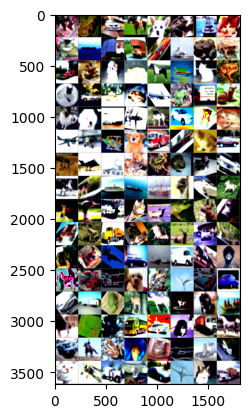

  dog  frog   car horse   dog   cat  ship   cat   cat  ship truck truck   car  ship  frog  frog truck  frog   dog  frog horse plane   cat  frog   cat   car horse  frog plane  frog truck   cat   dog   dog  ship plane   dog   car   dog  frog plane plane plane   dog truck truck  frog   car  deer plane truck  frog  frog  frog   cat   car horse   dog  ship  ship  ship  bird horse   dog  deer  bird  deer   cat  deer  frog  deer horse   cat  frog truck   cat  deer  deer   car  frog truck   dog plane   car  ship truck horse  bird   dog truck truck   dog  frog  bird   car   car plane truck  frog  deer horse horse   dog  ship  deer  deer  bird truck  ship   dog truck horse   car horse  frog   cat   cat  ship truck   car   cat plane truck   cat   car plane   cat truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

In [6]:
import torchvision.models as models
model_ft = models.wide_resnet50_2(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.Linear(512, 10))
net = model_ft

In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay = 2e-05, momentum = 0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)

In [8]:
device = torch.device('cuda:3')
net = net.to(device)
criterion = criterion.to(device)

In [9]:
def test(model, loader):
    correct = 0.0
    total = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * correct / total))
    return (correct/total) * 100

In [10]:
from tqdm import tqdm
from tensorboardX import SummaryWriter
writer = SummaryWriter()
writer.add_text("Params: ", "Supermodel")
counter = 0

for epoch in range(30):  # loop over the dataset multiple times
    running_loss = []
    net.train()
    pbar = tqdm(trainloader)
    total = 0.0
    correct = 0.0
    for i, data in enumerate(pbar, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # print statistics
        running_loss.append(loss.item())
        pbar.set_description("Loss is: %f" % (loss.item()) )
        if i % 20 == 1:    # print every 2000 mini-batches
            counter += 1
            writer.add_scalar("Loss", torch.mean(torch.tensor(running_loss)), counter)
            running_loss = []
    scheduler.step()
    test_accuracy = test(net, testloader)
    writer.add_scalar("Test Accuracy", test_accuracy, epoch+1)
    writer.add_scalar("Train Accuracy", (correct/total) * 100, epoch+1)
print('Finished Training')

Loss is: 0.302381: 100%|██████████| 391/391 [03:35<00:00,  1.82it/s]


Accuracy of the network on the 10000 test images: 94.290000 %


Loss is: 0.238089: 100%|██████████| 391/391 [03:34<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 96.280000 %


Loss is: 0.209729: 100%|██████████| 391/391 [03:34<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 96.540000 %


Loss is: 0.161145: 100%|██████████| 391/391 [03:34<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 96.920000 %


Loss is: 0.168176: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 96.880000 %


Loss is: 0.180389: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 96.910000 %


Loss is: 0.078097: 100%|██████████| 391/391 [03:34<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.150000 %


Loss is: 0.302640: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.230000 %


Loss is: 0.102013: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.490000 %


Loss is: 0.104530: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.470000 %


Loss is: 0.115866: 100%|██████████| 391/391 [03:33<00:00,  1.84it/s]


Accuracy of the network on the 10000 test images: 97.200000 %


Loss is: 0.175705: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]


Accuracy of the network on the 10000 test images: 97.430000 %


Loss is: 0.070433: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.560000 %


Loss is: 0.023712: 100%|██████████| 391/391 [03:33<00:00,  1.84it/s]


Accuracy of the network on the 10000 test images: 97.530000 %


Loss is: 0.111372: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]


Accuracy of the network on the 10000 test images: 97.600000 %


Loss is: 0.082353: 100%|██████████| 391/391 [03:33<00:00,  1.84it/s]


Accuracy of the network on the 10000 test images: 97.680000 %


Loss is: 0.053614: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.560000 %


Loss is: 0.084446: 100%|██████████| 391/391 [03:33<00:00,  1.84it/s]


Accuracy of the network on the 10000 test images: 97.610000 %


Loss is: 0.102103: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]


Accuracy of the network on the 10000 test images: 97.640000 %


Loss is: 0.116736: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.640000 %


Loss is: 0.067041: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.580000 %


Loss is: 0.031041: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.640000 %


Loss is: 0.074279: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.570000 %


Loss is: 0.046292: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.630000 %


Loss is: 0.224778: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.590000 %


Loss is: 0.022242: 100%|██████████| 391/391 [03:33<00:00,  1.84it/s]


Accuracy of the network on the 10000 test images: 97.580000 %


Loss is: 0.069797: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.610000 %


Loss is: 0.080158: 100%|██████████| 391/391 [03:33<00:00,  1.84it/s]


Accuracy of the network on the 10000 test images: 97.670000 %


Loss is: 0.022838: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.630000 %


Loss is: 0.036612: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]


Accuracy of the network on the 10000 test images: 97.690000 %
Finished Training


In [11]:
PATH = './cifar_wideresnet_epoc_30_all.pth'
torch.save(net.state_dict(), PATH)

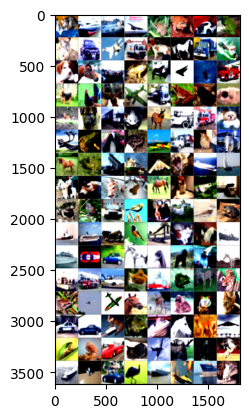

GroundTruth:    cat  ship  ship plane


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
net = model_ft
net.load_state_dict(torch.load(PATH))
net = net.to(device)

In [14]:
outputs = net(images.to(device))

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97.690000 %
